**Aim:** Write a program to implement ensemble algorithms- AdaBoost and Bagging using the appropriate
dataset and evaluate their performance on that dataset.

**Theory:** 
1. **AdaBoost**
Boosting refers to a class of machine learning ensemble algorithms where
models are added sequentially and later models in the sequence correct the
predictions made by earlier models in the sequence.
AdaBoost, short for “Adaptive Boosting,” is a boosting ensemble machine
learning algorithm, and was one of the first successful boosting approaches.
We call the algorithm AdaBoost because, unlike previous algorithms, it adjusts
adaptively to the errors of the weak hypotheses. AdaBoost combines the
predictions from short one-level decision trees, called decision stumps,
although other algorithms can also be used. Decision stump algorithms are
used as the AdaBoost algorithm seeks to use many weak models and correct
their predictions by adding additional weak models.
2. **Bagging**
Bootstrap Aggregation, or Bagging for short, is an ensemble machine learning
algorithm. Specifically, it is an ensemble of decision tree models, although the
bagging technique can also be used to combine the predictions of other types
of models. As its name suggests, bootstrap aggregation is based on the idea of
the “bootstrap” sample. A bootstrap sample is a sample of a dataset with
replacement. Replacement means that a sample drawn from the dataset is
replaced, allowing it to be selected again and perhaps multiple times in the
new sample. This means that the sample may have duplicate examples from
the original dataset. The bootstrap sampling technique is used to estimate a
population statistic from a small data sample. This is achieved by drawing
multiple bootstrap samples, calculating the statistic on each, and reporting the
mean statistic across all samples.

**Code:**
Dataset Used is **Iris Dataset**<br>
Importing Libraries

In [32]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

import sys
import random
import matplotlib.pyplot as plt

In [33]:
df=pd.read_csv('datasets_19_420_Iris.csv')
df=df.drop(columns=['Id'])
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [34]:
le=LabelEncoder()

df['Species']=le.fit_transform(df['Species'])
    

# Adaboost Implementation


In [35]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [36]:
def print_error_rate(err):
    print ('Error rate: Training: %.4f - Test: %.4f' % err)

In [37]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [38]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [39]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [40]:
X=df.drop(columns=['Species'])
y=df['Species']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [42]:
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(y_train, X_train, y_test, X_test, clf_tree)

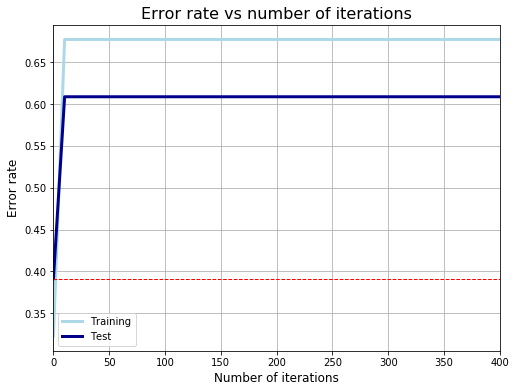

In [43]:
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    er_i = adaboost_clf(y_train, X_train, y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

# Bagging Implementation

In [44]:
class BaggingClassifier:
    """
    Bagging classifier.
    Note that the variable 'datum' in this code refers to a counter of features
    (not to a raw samples.Datum).
    
    """

    def __init__( self, legalLabels, max_iterations, weak_classifier, ratio, num_classifiers):

        self.ratio = ratio
        self.num_classifiers = num_classifiers
        self.classifiers = [weak_classifier(legalLabels, max_iterations) for _ in range(self.num_classifiers)]

    def train( self, trainingData, trainingLabels):
        """
        The training loop samples from the data "num_classifiers" time. Size of each sample is
        specified by "ratio". So len(sample)/len(trainingData) should equal ratio. 
        """

        self.features = trainingData[0].keys()
        
        sample_size = int(self.ratio * len(trainingData))
        for i in range(self.num_classifiers):
            random_integers = np.random.randint(len(trainingData), size = sample_size)
            sampled_data = []
            sampled_labels = []
            for choosen_element in random_integers:
                sampled_data.append(trainingData[choosen_element])
                sampled_labels.append(trainingLabels[choosen_element])

            self.classifiers[i].train(sampled_data, sampled_labels, None)






    def predict( self, data):
        """
        Classifies each datum as the label that most closely matches the prototype vector
        for that label. This is done by taking a polling over the weak classifiers already trained.
        
        Recall that a datum is a util.counter.
        The function should return a list of labels where each label should be one of legaLabels.
        """

       
        prediction = []
        for i in range(len(data)):
            guesses = []
            for j in range(self.num_classifiers):
                guesses.append(self.classifiers[j].classify([data[i]])[0])

            prediction.append(int(np.sign(sum(guesses))))

        return prediction


In [ ]:

bgclf=BaggingClassifier(base_estimator=SVC(),n_estimators=3,random_state=0).fit(X,y)
y_predict=bgclf.predict(X_test)




In [47]:
corr=0
y_test=y_test.to_numpy()
for i in range(len(X_test)):
    if y_test[i]==y_predict[i]:
        corr += 1

print("Accuracy: {}".format(corr/len(y_test)*1.0))        

Accuracy: 1.0
